#### Loading required libraries 

In [ ]:
# path
import project_path

# matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split

#scipy
from scipy import stats

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 7 , 5


# Using data generated from medium class 

#### Loading prepared datasets 

In [ ]:
X_train = pd.read_csv('../../data/processed/1.generating_from_medium_class/X_train.csv',index_col=0)
y_train = pd.read_csv('../../data/processed/1.generating_from_medium_class/y_train.csv',index_col=0).quality

X_test = pd.read_csv('../../data/processed/1.generating_from_medium_class/X_test.csv',index_col=0)
y_test = pd.read_csv('../../data/processed/1.generating_from_medium_class/y_test.csv',index_col=0).quality

X_val = pd.read_csv('../../data/processed/1.generating_from_medium_class/X_val.csv',index_col=0)
y_val = pd.read_csv('../../data/processed/1.generating_from_medium_class/y_val.csv',index_col=0).quality

np.bincount(y_train), np.bincount(y_test),np.bincount(y_val)


##### Weights

In [ ]:
# it is need to catch high _quality wine. Thus, increasing high_quality wine class weight:
class_weight = {0:.1, 1:1, 2:100}
class_weight

#### Loading ML libraries and fitting to train dataset

In [ ]:
# loading sklearn libraries

# --- one algoritm classificators ---
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# --- ensembles ---
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier

# --- metrics ---
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
# initiate classificators

# --- one algoritm classifiers ---

svc = SVC(class_weight=class_weight, random_state=255,
          decision_function_shape='ovo')

logit = LogisticRegression(class_weight=class_weight,
                           max_iter=300, multi_class='multinomial', n_jobs=-1)

# --- ensembles ---

rf = RandomForestClassifier(
    n_estimators=300, n_jobs=-1, random_state=255, class_weight=class_weight)

bag = BaggingClassifier(base_estimator=logit, n_estimators=50, n_jobs=-1)

lgc = LGBMClassifier(
    n_estimators=300, class_weight=class_weight, random_state=255, n_jobs=-1)


classifiers = [
    ('logit', logit),
    ('dt', DecisionTreeClassifier(max_features=1, class_weight=class_weight)),
    ('svc', svc ),
    ('lgc', lgc) 
]

st = StackingClassifier(estimators=classifiers,
                        final_estimator=logit, n_jobs=-1)

In [ ]:
# rs
algoritms = [
   {'name': 'RandFrst', 'model': RandomForestClassifier(n_jobs=-1, class_weight=class_weight), 'params': {'n_estimators': list(
       range(100, 500, 1)), 'criterion': ["gini", "entropy"], 'max_depth':list(range(5, 100))+[None], 'ccp_alpha':np.arange(.1, 2, .1)}},

    {'name': 'Svc', 'model': SVC(class_weight=class_weight, random_state=255,
        decision_function_shape='ovo'), 'params': {'C':np.arange(.1, 2, .1)}},

    {'name': 'BagTree', 'model': BaggingClassifier(n_jobs=-1), 'params': {'base_estimator': [
        RandomForestClassifier(n_jobs=-1, class_weight=class_weight), DecisionTreeClassifier(class_weight=class_weight)], 'n_estimators':list(range(3, 23))}},

    {'name': 'BagLogit', 'model': BaggingClassifier(n_jobs=-1), 'params': {'base_estimator': [LogisticRegression(
        solver='saga', penalty='elasticnet', n_jobs=-1, l1_ratio=.5,class_weight=class_weight)], 'n_estimators':list(range(3, 23))}},

    {'name': 'Logit', 'model': LogisticRegression(solver='saga', multi_class='multinomial',penalty='elasticnet', n_jobs=-1, max_iter=1000,class_weight=class_weight),
     'params': {'C':np.arange(0, 5, .2), 'l1_ratio':list(np.arange(0, 1.01, .01))}},
    
    {'name': 'LGC', 'model': LGBMClassifier( n_jobs=-1, random_state=255,class_weight=class_weight),
     'params': {'n_estimators': list(range(100, 300, 100)),'learning_rate':list(np.arange(0.1, 1.1, .1)),  'reg_alpha':list(np.arange(0, 1.1, .1)) }}
    
]

In [ ]:
# rs
#results = []

for algo in algoritms:
    results.append((  algo['name'],  RandomizedSearchCV(algo['model'],algo['params'], cv=4 ).fit(X_train,y_train)    ))

In [174]:
for result in results:
    print(f'{result[0]}. Train_score= {result[1].best_score_ :.3f} \n {result[1].best_params_}')
    print('-'*105)

RandFrst. Train_score= 0.435 
 {'n_estimators': 148, 'max_depth': 85, 'criterion': 'gini', 'ccp_alpha': 0.5}
---------------------------------------------------------------------------------------------------------
Svc. Train_score= 0.796 
 {'C': 1.9000000000000001}
---------------------------------------------------------------------------------------------------------
BagTree. Train_score= 0.896 
 {'n_estimators': 21, 'base_estimator': DecisionTreeClassifier(class_weight={0: 0.1, 1: 1, 2: 100})}
---------------------------------------------------------------------------------------------------------
BagLogit. Train_score= 0.761 
 {'n_estimators': 17, 'base_estimator': LogisticRegression(class_weight={0: 0.1, 1: 1, 2: 100}, l1_ratio=0.5, n_jobs=-1,
                   penalty='elasticnet', solver='saga')}
---------------------------------------------------------------------------------------------------------
Logit. Train_score= 0.746 
 {'l1_ratio': 0.76, 'C': 4.0}
--------------------

In [173]:
algoritm_results = {'name':[],
                   'medium_quality_precision':[],
                    'medium_quality_recall':[],
                   'high_quality_precision':[],
                   'high_quality_recall':[]}

for result in results: 
    print('Estimator', result[0])
    
    best_estimator = result[1].best_estimator_
    y_pred = best_estimator.predict(X_val)

    print(classification_report(y_val, y_pred, target_names=[
      'low_quality_wine', 'medium_quality_wine', 'high_quality_wine'],zero_division=1, sample_weight=y_val.map(class_weight)))

    algoritm_results['name'].append(result[0])
    a = classification_report(y_val, y_pred, output_dict=True,zero_division=1, sample_weight=y_val.map(class_weight))
    
    algoritm_results['medium_quality_precision'].append(a['1']['precision'])
    algoritm_results['medium_quality_recall'].append(a['1']['recall'])
    
    algoritm_results['high_quality_precision'].append(a['2']['precision'])
    algoritm_results['high_quality_recall'].append(a['2']['recall'])
    
    print('-'*105)

Estimator RandFrst
                     precision    recall  f1-score   support

   low_quality_wine       1.00      0.00      0.00       4.5
medium_quality_wine       1.00      0.00      0.00     994.0
  high_quality_wine       0.83      1.00      0.91    5000.0

           accuracy                           0.83    5998.5
          macro avg       0.94      0.33      0.30    5998.5
       weighted avg       0.86      0.83      0.76    5998.5

---------------------------------------------------------------------------------------------------------
Estimator Svc
                     precision    recall  f1-score   support

   low_quality_wine       1.00      0.00      0.00       4.5
medium_quality_wine       0.99      0.67      0.80     994.0
  high_quality_wine       0.94      1.00      0.97    5000.0

           accuracy                           0.94    5998.5
          macro avg       0.98      0.56      0.59    5998.5
       weighted avg       0.95      0.94      0.94    5998.5

-

In [172]:
print('Algoritm results on VALIDATION dataset')
algoritm_results_df = pd.DataFrame(algoritm_results)
algoritm_results_df

Algoritm results on VALIDATION dataset


,name,medium_quality_precision,medium_quality_recall,high_quality_precision,high_quality_recall
0,RandFrst,1.000000,0.000000,0.833542,1.00
1,Svc,0.994780,0.671026,0.938438,1.00
2,BagTree,0.282157,0.950704,0.983284,0.52
3,BagLogit,0.994541,0.586519,0.923822,1.00
4,Logit,0.994647,0.579477,0.922611,1.00
5,LGC,0.280687,0.943662,0.981428,0.52


The best Algoritm is in TOP RIGHT corner! 
---------------------------------------------------------------------------------------------------------


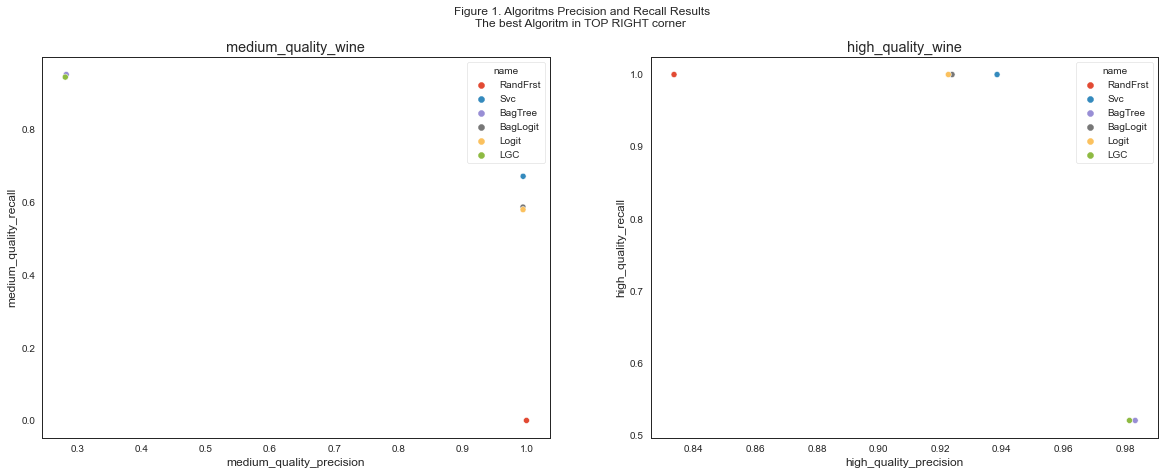

In [171]:
print('The best Algoritm is in TOP RIGHT corner! ')
print('-'*105)

fig, (ax0,ax1) = plt.subplots( nrows=1, ncols=2, figsize=(20,7) )

ax0.set_title('medium_quality_wine')
sns.scatterplot(algoritm_results_df.medium_quality_precision,
                algoritm_results_df.medium_quality_recall ,hue=algoritm_results_df.name, ax=ax0)

ax1.set_title('high_quality_wine')
sns.scatterplot(algoritm_results_df.high_quality_precision,
                algoritm_results_df.high_quality_recall ,hue=algoritm_results_df.name, ax=ax1)

fig.suptitle('Figure 1. Algoritms Precision and Recall Results\nThe best Algoritm in TOP RIGHT corner ')
fig.savefig('Algoritms Precision and Recall Results.png')
plt.show()


## ML part Conclusion:
1. The best estimator is __SVC - Support Vector Classifier__ because it has the highest medium and high quality wines recall and precision
1. The second estimator is __BagLogit - Bagging with logit__ as per medium and high quality wines recall and precision(please see the figure 1 above)
1. The third estimator is __Logit__ as per medium and high quality wines recall and precision(please see the figure 1 above)

In [170]:
print('Best estimator  SVC params:')
print(results[1][1].best_estimator_.get_params())

Best estimator  SVC params:
{'C': 1.9000000000000001, 'break_ties': False, 'cache_size': 200, 'class_weight': {0: 0.1, 1: 1, 2: 100}, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 255, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
#saving ML models
import pickle

with open('./ML_algo_params/Best_ML_algo_SVC_params.pickle','wb') as f:
    pickle.dump(results[1][1].best_estimator_.get_params(),f  )
f.close()


for result in results:
    with open(f'./ML_algo_params/ML_algo_{result[0]}_params.pickle','wb') as f:
        pickle.dump(result[1].best_estimator_.get_params(),f  )
    f.close()

## NN Part

In [ ]:
# loading NN libraries and visualisation function
import tensorflow as tf
import keras

import project_path
from  py_scripts.make_plots import make_plots


In [175]:
#Define model
model_1 = keras.Sequential([
    keras.Input(shape=X_train.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(32,activation='softmax'),
    keras.layers.Dense(3,activation = 'softmax')
])

#summary
print(model_1.summary() )

# compile
model_1.compile(optimizer='adam', 
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=keras.metrics.sparse_categorical_accuracy)
#callbacks
callback = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_1.{epoch:03d}-loss_{val_loss:5.2f}-acc_{val_sparse_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        save_freq='epoch',
        mode='max') ]

#train
history = model_1.fit(X_train,
               y_train,
               batch_size=15,
               epochs=30,
               validation_data=(X_val,y_val),
               class_weight=class_weight,
               callbacks=callback,
               verbose=0)
print('Done!')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                416       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________________
None
Done!


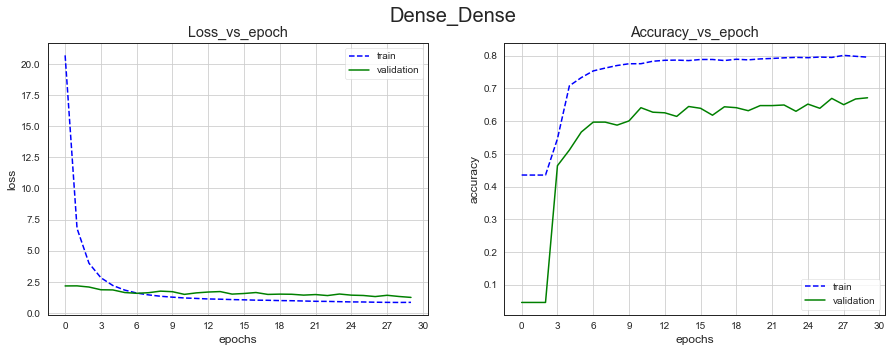

In [176]:
make_plots(model_1,name='Dense_Dense',save=True)

In [ ]:
#making NN comprison dict and saving results
NN_algoritm_results = {'name':[],
                   'medium_quality_precision':[],
                    'medium_quality_recall':[],
                   'high_quality_precision':[],
                   'high_quality_recall':[]}

def save_model_results(y_pred, name='Test'):
    NN_algoritm_results['name'].append(name)
    a = classification_report(y_val, y_pred, output_dict=True,zero_division=1, sample_weight=y_val.map(class_weight))

    NN_algoritm_results['medium_quality_precision'].append(a['1']['precision'])
    NN_algoritm_results['medium_quality_recall'].append(a['1']['recall'])

    NN_algoritm_results['high_quality_precision'].append(a['2']['precision'])
    NN_algoritm_results['high_quality_recall'].append(a['2']['recall'])
    
    return None

In [177]:
y_pred = model_1.predict(X_val)
y_pred= np.argmax(y_pred,axis=1)

acc = accuracy_score(y_val,y_pred,sample_weight = np.array(y_val.map(class_weight)))
print('accuracy score = ',round(acc,3))

save_model_results(y_pred, name='Dense(32)+Dense(32)')

print(classification_report(y_val, y_pred, 
        target_names=['low_quality_wine', 'medium_quality_wine', 'high_quality_wine'],
        zero_division=1, sample_weight=y_val.map(class_weight))  )

accuracy score =  0.947
                     precision    recall  f1-score   support

   low_quality_wine       1.00      0.00      0.00       4.5
medium_quality_wine       0.99      0.69      0.81     994.0
  high_quality_wine       0.94      1.00      0.97    5000.0

           accuracy                           0.95    5998.5
          macro avg       0.98      0.56      0.59    5998.5
       weighted avg       0.95      0.95      0.94    5998.5



__Result__:

The simple NN algoritm showed the same result (precision, recall) as the best ML algoritm.


It will be built a bit complicated model to increace 'catching' precision.

In [ ]:
# saving the model
model_1.save('model_1_Dense_Dense')

### Final Model
preliminary models calculated and saved on drive

In [208]:
#Define a model that utilizes bidirectional SimpleRNN
model_2 = keras.models.Sequential()

# make shape of features values acceptable to RNN layer
X_train_reshaped =  np.array(X_train).reshape(X_train.shape[0],-1,X_train.shape[1])
X_val_reshaped =  np.array(X_val).reshape(X_val.shape[0],-1,X_val.shape[1])

#input
model_2.add(keras.layers.Input(shape=X_train_reshaped.shape[1:],dtype=np.float32 ))

#make bidirectional  LSTM
LSTM_layer = keras.layers.LSTM(units = 16,
          activation = 'tanh',
          recurrent_activation = 'sigmoid', 
          return_sequences=True) 
model_2.add( keras.layers.Bidirectional(LSTM_layer) )

# #make Conv1D
# model_2.add( keras.layers.Convolution1D(filters=64, kernel_size=3,padding='same', 
#                             activation = keras.activations.relu ) )

# #make Conv1D
# model_2.add( keras.layers.Convolution1D(filters=32, kernel_size=2,padding='same', 
#                             activation = keras.activations.relu ) )

model_2.add( keras.layers.Flatten() )

#make 2 Dense layers
model_2.add( keras.layers.Dense(64,activation=keras.activations.relu) )
#model_2.add( keras.layers.Dropout(.3) )

model_2.add( keras.layers.Dense(32,activation=keras.activations.relu) )
#model_2.add( keras.layers.Dropout(.1) )

# output
model_2.add( keras.layers.Dense(3,activation=keras.activations.softmax) )

#summary
print(model_2.summary() )

# compile
model_2.compile(optimizer='adam', 
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=keras.metrics.sparse_categorical_accuracy)

#callbacks
callback = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/model_2.{epoch:03d}-val_loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        save_freq='epoch',
        mode='min') ]

#train
history = model_2.fit(X_train_reshaped,
               y_train,
               batch_size=3,
               epochs=100,
               validation_data=(X_val_reshaped,y_val),
               class_weight=class_weight,
               verbose=0,
               callbacks=callback)

print('Done!')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 1, 32)             3712      
_________________________________________________________________
flatten_11 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 99        
Total params: 8,003
Trainable params: 8,003
Non-trainable params: 0
_________________________________________________________________
None
Done!


In [ ]:
# build calulation graph to increase calculation speed 
@tf.function  
def predict(model,array):
    return model(array)

In [ ]:
# make function to calculate accuracy by batches

from tqdm.notebook import tqdm

def accuracy_for_batch_model(model,batch_size,test_X, test_y):
    y_pred_all = np.array([])
    batches = len(test_X)//batch_size
    
    for i in tqdm(range(0,batches,1)):
        
        y_pred = np.array( predict(model,test_X[i*3:i*3+3]) )
        y_pred = y_pred.reshape(3,-1)
        y_pred = np.ravel( np.argmax(y_pred,axis=1) )
        y_pred_all = np.append(y_pred_all, y_pred )
    
    if len(test_y)>len(y_pred_all):
        
        a= len(test_y) - len(y_pred_all)
        y_pred = np.array( predict(model,test_X[-3:]) )
        y_pred = y_pred.reshape(3,-1)
        y_pred = np.ravel( np.argmax(y_pred,axis=1) )
        y_pred_all = np.append(y_pred_all, y_pred[-a:] )
        
    acc = accuracy_score(test_y ,y_pred_all, sample_weight = np.array(test_y.map(class_weight)))
    
    return acc, y_pred_all

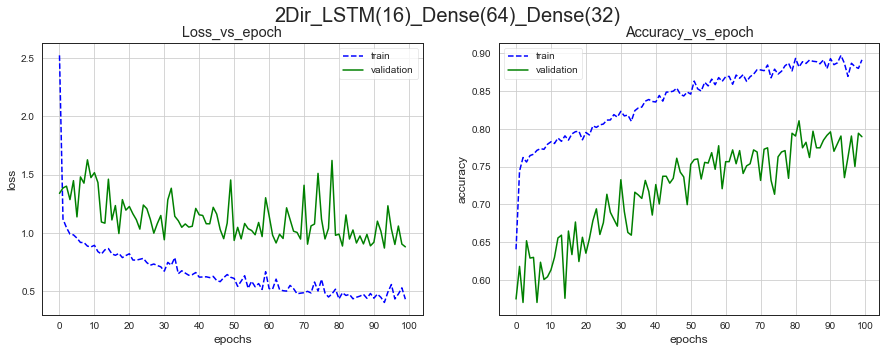

In [210]:
make_plots(model_2,name='2Dir_LSTM(16)_Dense(64)_Dense(32)',save=True)

In [211]:
# check validation result

acc,y_pred = accuracy_for_batch_model(model=model_2, batch_size=3,test_X=X_val_reshaped,test_y=y_val)
print('accuracy score = ',acc)

print(classification_report(y_val, y_pred, 
        target_names=['low_quality_wine', 'medium_quality_wine', 'high_quality_wine'],
        zero_division=1, sample_weight=y_val.map(class_weight))  )


accuracy score =  0.968575477202634
                     precision    recall  f1-score   support

   low_quality_wine       0.00      0.00      0.00       4.5
medium_quality_wine       0.99      0.81      0.90     994.0
  high_quality_wine       0.96      1.00      0.98    5000.0

           accuracy                           0.97    5998.5
          macro avg       0.65      0.60      0.63    5998.5
       weighted avg       0.97      0.97      0.97    5998.5



In [ ]:
save_model_results(y_pred, name='2Dir_LSTM(16)_Dense(64)_Dense(32)')

# saving the model
model_2.save('2Dir_LSTM(16)_Dense(64)_Dense(32)')

In [209]:
NN_algoritm_results_df = pd.DataFrame(NN_algoritm_results)
NN_algoritm_results_df

,name,medium_quality_precision,medium_quality_recall,high_quality_precision,high_quality_recall
0,Dense(32)+Dense(32),0.994988,0.679074,0.939832,1.0
1,2Dir_LSTM_Conv_Conv_Dense_Dense,0.994814,0.733400,0.949541,1.0
2,2Dir_LSTM(16)_Dense(64)_Dense(32),0.994997,0.720322,0.947167,1.0
3,2Dir_LSTM(16)_Conv(64)_Dense(64)_Dense(32),0.995157,0.640845,0.933114,1.0
4,LSTM(16)_Dense(64)_Dense(32),0.994884,0.567404,0.920539,1.0
5,RNN(16)_Conv(64)_Conv(32)_Dense(64)_Dense(32),0.994811,0.559356,0.919185,1.0
6,RNN(16)_Dense(64)_Dense(32),0.994521,0.602616,0.926578,1.0
7,2Dir_RNN(16)_Conv(64)_Conv(32)_Dense(64)_Dense...,0.994638,0.578471,0.922441,1.0


The best Algoritm is in TOP RIGHT corner! 
---------------------------------------------------------------------------------------------------------


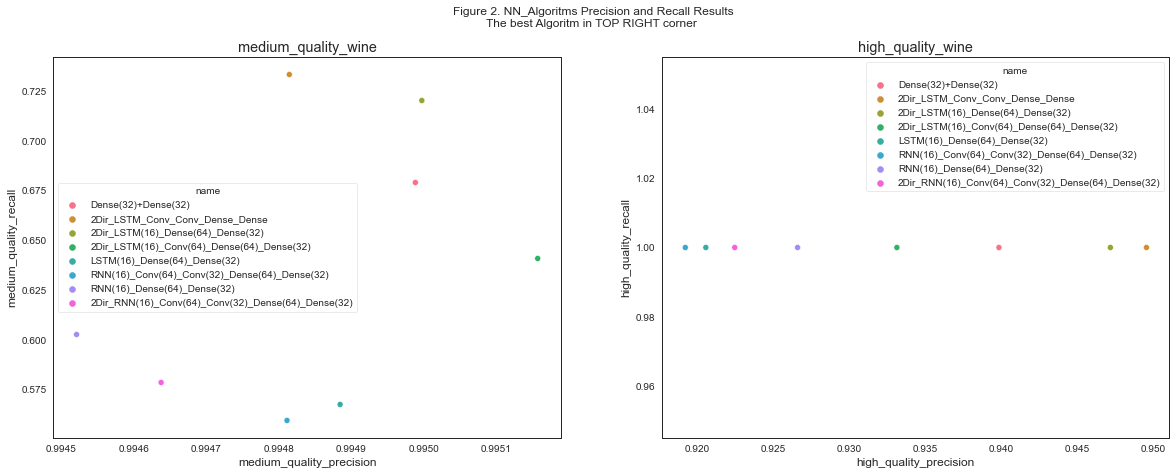

In [207]:
print('The best Algoritm is in TOP RIGHT corner! ')
print('-'*105)

fig, (ax0,ax1) = plt.subplots( nrows=1, ncols=2, figsize=(20,7) )

ax0.set_title('medium_quality_wine')
sns.scatterplot(NN_algoritm_results_df.medium_quality_precision,
                NN_algoritm_results_df.medium_quality_recall ,hue=NN_algoritm_results_df.name, ax=ax0)

ax1.set_title('high_quality_wine')
sns.scatterplot(NN_algoritm_results_df.high_quality_precision,
                NN_algoritm_results_df.high_quality_recall ,hue=NN_algoritm_results_df.name, ax=ax1)

fig.suptitle('Figure 2. NN_Algoritms Precision and Recall Results\nThe best Algoritm in TOP RIGHT corner ')
fig.savefig('NN_Algoritms Precision and Recall Results.png')
plt.show()

## NN part Conclusion:
1. The best combination is __2Directional LSTM + Dense + Dense__ because it has the highest medium and high quality wines recall and precision
1. The second estimator is __2Directional LSTM + Conv + Conv + Dense + Dense__ as per medium and high quality wines recall and precision(please see the figure 2 above)


## Checking results for the Test dataset

In [213]:
# check final result

X_test_reshaped =  np.array(X_test).reshape(X_test.shape[0],-1,X_test.shape[1])

acc,y_pred = accuracy_for_batch_model(model=model_2, batch_size=3,test_X=X_test_reshaped,test_y=y_test)
print('accuracy score = ',acc)

print(classification_report(y_test, y_pred, 
        target_names=['low_quality_wine', 'medium_quality_wine', 'high_quality_wine'],
        zero_division=1, sample_weight=y_test.map(class_weight))  )


accuracy score =  0.7132022644760323
                     precision    recall  f1-score   support

   low_quality_wine       1.00      0.02      0.03 6.399999999999993
medium_quality_wine       0.43      0.83      0.57    1494.0
  high_quality_wine       0.93      0.68      0.79    5000.0

           accuracy                           0.71    6500.4
          macro avg       0.79      0.51      0.46    6500.4
       weighted avg       0.82      0.71      0.74    6500.4



In [219]:
a = pd.DataFrame(data=[70,83],columns=['Recall, %'],index=['high_quality', 'medium_quality'])
a['Precision, %'] = 93,43

a

,"Recall, %","Precision, %"
high_quality,70,93
medium_quality,83,43


### Model appraisal
__Document Conclusions__:

- Dataset has unbalanced classes. For example we deal with:
    - low_qiality_wines = 250 samples, 
    - medium_qiality_wines = 6250 samples,
    - high_qiality_wines = 5 samples.
- To correctly measure high_qiality_wines, 100 duplicates of high_quality wines were added in valiation and test datasets, 
- Also (for train purpouse) __quasi- high_qiality_wines__ were added in train dataset,
- Quasi- high_qiality_wines were made by fitting(upgrading) medium_quality_wine to high_quality (please see paragraph 4.2),

__Model appraisal__:
- The final model (model_2) found all high_quality wines with percision 70% and recall 100%
- The final model_2 consists of: Bidirectional_LSTM(16) + Dense(64) + Dense(32)

###   Project goal correspondence check.
__The project goals__:
- The project goal №1 was to catch all high_qiality_wines and the goal is achieved (f1 score 88%).
- The project goal №2 was to catch all medium_qiality_wines and the goal is achieved (f1 score 95%).
- The project goal №3 both above mentioned algoritms are combined in one algoritm (model_2)